In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import display, HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 12]
    plt.rcParams['font.size'] = 15
    
    display( HTML( '<style>.container { width:70% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', True )
    

In [3]:
jupyter_settings()

In [6]:
def get_boolean_columns(df):
    """
    This function takes a DataFrame as input and returns a list of column names containing boolean values ('f' or 't').

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.

    Returns:
        bool_columns (list): A list of column names containing boolean values ('f' or 't').
    """
    bool_columns = []
    for column in df.columns:
        has_bool_value = df[column].isin(['f', 't']).any() 
        if (has_bool_value):
            bool_columns.append(column)
    return bool_columns

## Gather Data

In [49]:
listings = pd.read_csv("data/listings.csv")

## Prepare Data

In [50]:
print(listings.isna().mean().sort_values(ascending=False))

license                                         1.000000
neighbourhood_group_cleansed                    1.000000
bathrooms                                       1.000000
calendar_updated                                1.000000
host_about                                      0.519261
neighborhood_overview                           0.479787
neighbourhood                                   0.479787
host_neighbourhood                              0.288194
review_scores_location                          0.251411
review_scores_value                             0.251378
review_scores_communication                     0.251378
review_scores_accuracy                          0.251378
review_scores_checkin                           0.251345
review_scores_cleanliness                       0.251345
reviews_per_month                               0.246227
first_review                                    0.246227
review_scores_rating                            0.246227
last_review                    

In [37]:
# Removing columns with NaN, because they will not be useful in the analysis.
# That includes the columns license, neighbourhood_group_cleansed, bathrooms, calendar_updated

print('listings.shape before dropping the NaN colum ==', listings.shape)
listings=listings.dropna(axis=1, how='all')
print('listings.shape after dropping the NaN columns ==', listings.shape)

listings.shape before dropping the NaN colum == (30476, 75)
listings.shape after dropping the NaN columns == (30476, 71)


In [39]:
#Dropping theses columns because they are not going to useful in this analysis, because i'm not interested 
# in any columns that contains url

listings.drop(listings.columns[listings.columns.str.contains("url")],axis=1,inplace=True)

In [51]:
# Convert the percentage values to numeric values for the purpose of performing mathematical operations.
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].str.rstrip('%').astype(float) / 100
listings['host_response_rate'] = listings['host_response_rate'].str.rstrip('%').astype(float) / 100
listings['price'] = listings['price'].str.replace(r"$","").str.replace(",","").astype("float32")

In [41]:
# Converting 'f' and 't' to boolean values, because is easier to understand.

listings_bool_columns = get_boolean_columns(listings)
listings[listings_bool_columns] = listings[listings_bool_columns].replace({'f': 0, 't': 1}).astype(float)

# Analyze - Business Understanding

## What's the proportion of super host?


In [42]:
listings.groupby(['host_is_superhost']).size()

host_is_superhost
0.0    23328
1.0     7141
dtype: int64

In [43]:
listings[listings['host_is_superhost'] == 1]['id'].count() / listings.shape[0]

0.23431552697204358

###  Only 23% of the hosts are super hosts in Rio  which is higher than the global average of 19.4%. My hypothesis is that, as the country’s foremost tourist hub, there is intense competition among hosts. This drives them to provide superior services and accommodations for their guests

## What is the average ratings for Superhost and non superhost hosts?

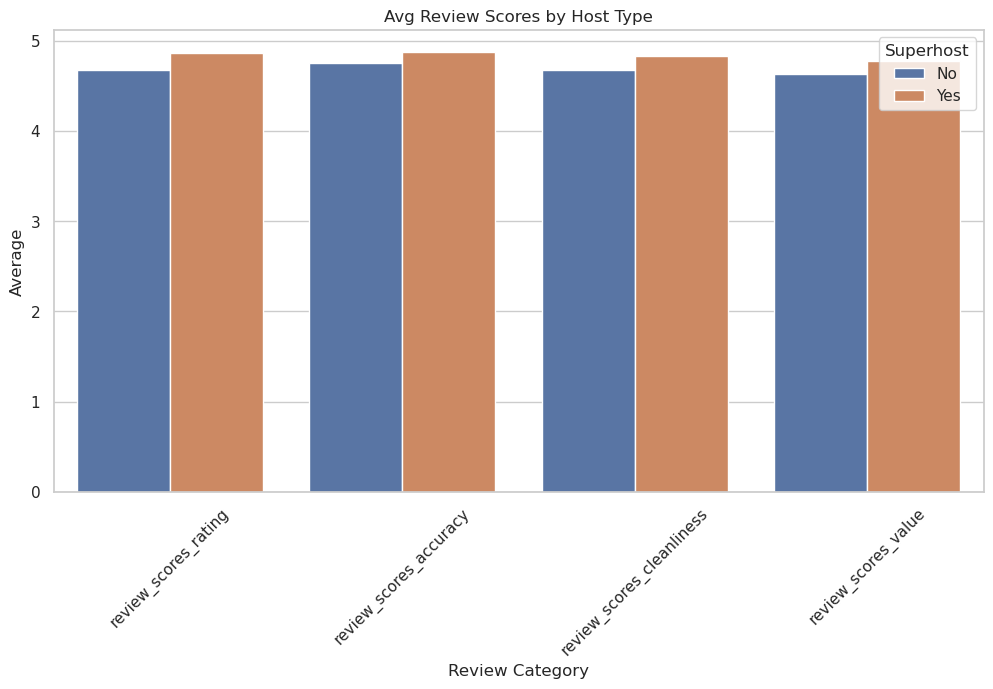

In [46]:
grouped_data = listings[
    [
        "host_is_superhost",
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_value",
    ]
].groupby(["host_is_superhost"]).mean().reset_index()

melted_data = grouped_data.melt(id_vars=["host_is_superhost"], var_name="review_category", value_name="mean_score")


# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="review_category", y="mean_score", data=melted_data,  hue=melted_data["host_is_superhost"].map(lambda x: "Yes" if x else "No"))
plt.title("Avg Review Scores by Host Type")
plt.xlabel("Review Category")
plt.ylabel("Average")
plt.xticks(rotation=45)
plt.legend(title="Superhost")
plt.show()

### Superhosts have an overall rating average of 4.86, while non-Superhosts have a slightly lower average of 4.67.

### The cleanliness rate for Superhosts is 4.82, compared to 4.67 for non-Superhosts. This demonstrates that Superhosts pay much attention to maintaining a clean and comfortable space for their guests.

###  Superhosts in Rio have an accuracy rate of 4.87, while non-Superhosts have a rate of 4.75. This shows that Superhosts are more precise and transparent in their listings, making sure that guests know exactly what to expect.

### Value is another category that sets superhost apart. The rate for Superhosts is 4.77, compared to 4.63 for non-Superhosts. This shows that guests feel they are getting a better deal with a Superhost.

## What are the top listed neighbourhoods?

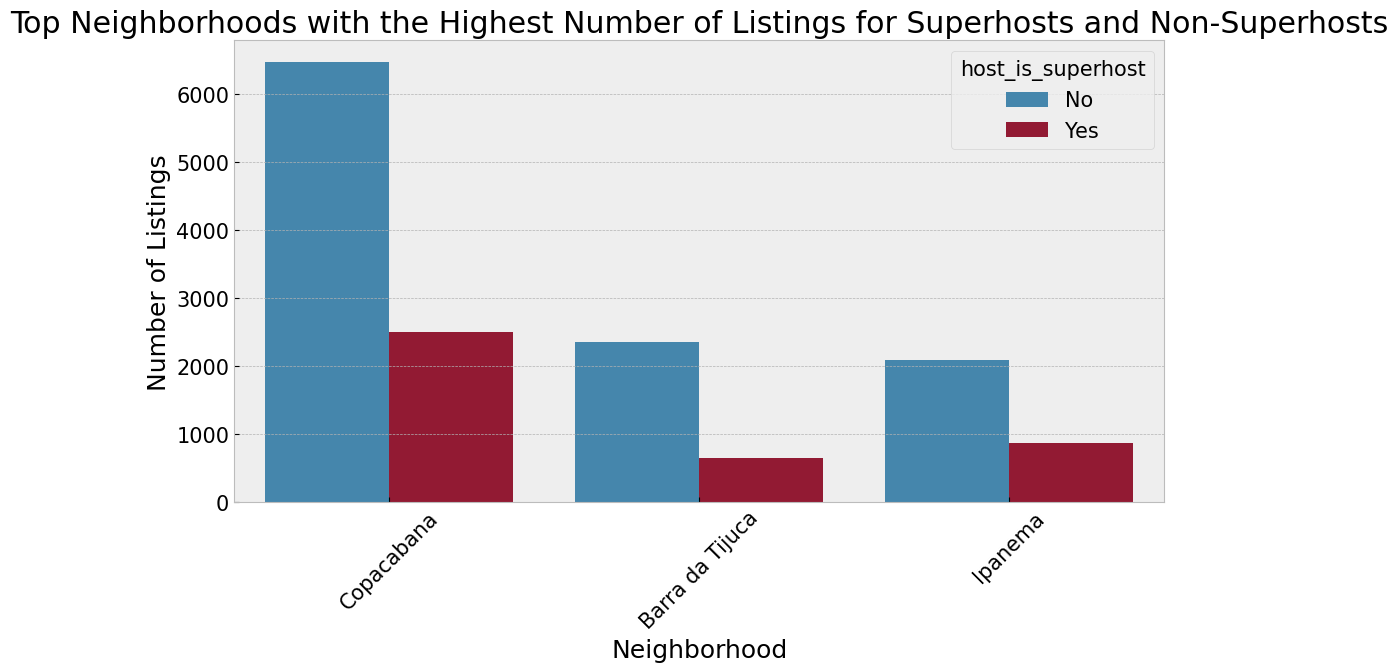

In [16]:
result = (
    listings.groupby(["host_is_superhost", "neighbourhood_cleansed"])
    .size()
    .reset_index(name="count")
)
top_neighborhoods = (
    result.groupby("host_is_superhost")
    .apply(lambda x: x.nlargest(3, "count"))
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_neighborhoods,
    x="neighbourhood_cleansed",
    y="count",
    hue=top_neighborhoods["host_is_superhost"].map(lambda x: "Yes" if x else "No"),
)

plt.title(
    "Top Neighborhoods with the Highest Number of Listings for Superhosts and Non-Superhosts"
)
plt.xlabel("Neighborhood")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)

plt.show()

### We can observe that both superhosts and non superhosts are concentrated in Copacabana, Barra da Tijuca, and Ipanema. This indicates that both types of hosts are concentrated in popular tourist areas, offering better all around experiences.

## What's the Response Time?

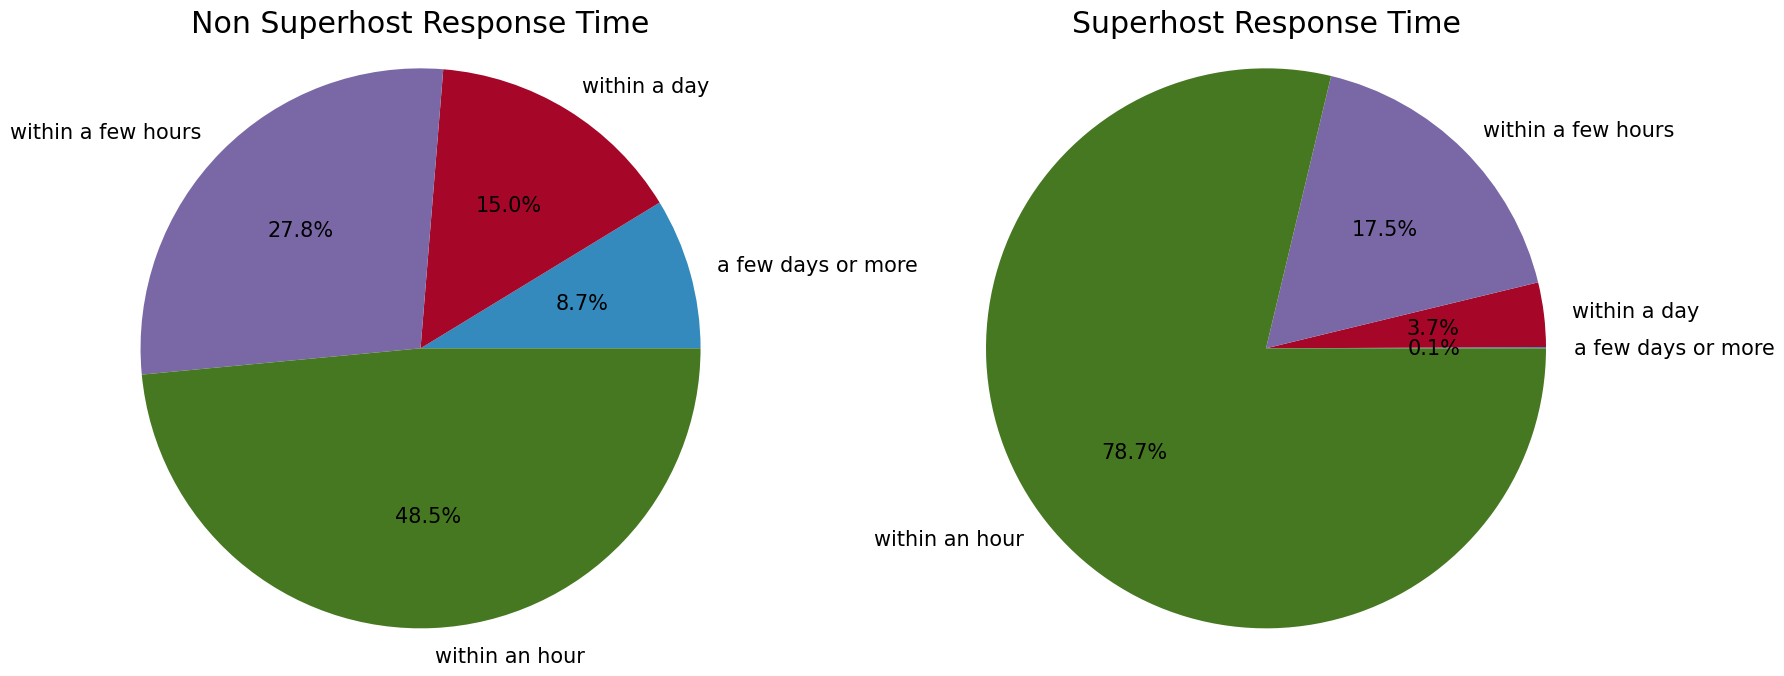

In [17]:
non_superhost = listings[listings["host_is_superhost"] == 0]
grouped_data_non_superhost = (
    non_superhost.groupby(["host_is_superhost", "host_response_time"])
    .size()
    .reset_index(name="count")
)
grouped_data_non_superhost["percentage"] = (
    grouped_data_non_superhost["count"]
    / grouped_data_non_superhost.groupby("host_is_superhost")["count"].transform("sum")
) * 100

superhost = listings[listings["host_is_superhost"] == 1]
grouped_data_superhost = (
    superhost.groupby(["host_is_superhost", "host_response_time"])
    .size()
    .reset_index(name="count")
)
grouped_data_superhost["percentage"] = (
    grouped_data_superhost["count"]
    / grouped_data_superhost.groupby("host_is_superhost")["count"].transform("sum")
) * 100


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))


axes[0].pie(
    grouped_data_non_superhost["percentage"],
    labels=grouped_data_non_superhost["host_response_time"],
    autopct="%1.1f%%",
)
axes[0].axis("equal")
axes[0].set_title("Non Superhost Response Time")

axes[1].pie(
    grouped_data_superhost["percentage"],
    labels=grouped_data_superhost["host_response_time"],
    autopct="%1.1f%%",
)
axes[1].axis("equal")
axes[1].set_title("Superhost Response Time")


plt.show()


### Essential for guest satisfaction. A staggering 78.7% of Superhosts respond within an hour, and 17.5% respond within a few hours.

### In contrast, 48.5% of non-Superhosts respond within an hour, and 27% respond within a few hours.

### This demonstrates that Superhosts are more attentive and responsive to their guests’ needs.

## What's the Acceptance Rate?

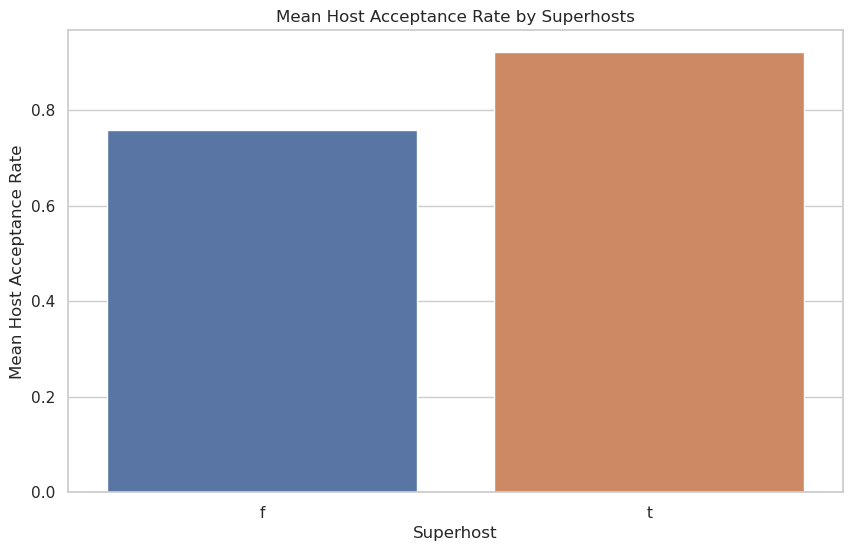

In [52]:
data = listings.groupby(['host_is_superhost'])['host_acceptance_rate'].mean().reset_index()

# Create the bar chart using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_chart = sns.barplot(x='host_is_superhost', y='host_acceptance_rate', data=data)

# Set the title and labels
plt.title('Mean Host Acceptance Rate by Superhosts')
plt.xlabel('Superhost')
plt.ylabel('Mean Host Acceptance Rate')

# Show the plot
plt.show()

### Superhosts have an acceptance rate of 92%, while non-Superhosts have a rate of 75%. This suggests that Superhosts are more likely to accommodate guests.